In [65]:
import os, sys, random
from numpy import mat
from pymatgen.ext.matproj import MPRester
from pymatgen.io.cif import CifParser, CifFile
import json
import csv
import subprocess
import matplotlib.pyplot as plt
import pandas as pd

In [66]:
API_TOKEN = os.environ.get("MPTOKEN")
# print(API_TOKEN)

In [67]:
## Read our candidates file and get the mp-ids

CANDIDATE_IDS = []
with open('../TMR_Data.json') as fo:
    data = json.load(fo)

for material in data['candidates']:
    CANDIDATE_IDS.append(material['material_id'])

print(CANDIDATE_IDS[:5])


['mp-1097065', 'mp-1189871', 'mp-1196573', 'mp-1245346', 'mp-1245448']


In [68]:
mpr = MPRester(API_TOKEN)

crt = {
    'material_id': {'$in': CANDIDATE_IDS},
}
prt = ['material_id', 'pretty_formula', 'icsd_ids', 'cif', 'elasticity']

cif_candidates = mpr.query(criteria=crt, properties=prt)



100%|██████████| 2236/2236 [00:15<00:00, 143.52it/s]


### Generate CIF files for the candidates

In [72]:
## Use 20 materials
ID_PROPS_DATA = []
count = 1
for i in cif_candidates:
    if i['elasticity'] is not None:
        print(f"processing {i['pretty_formula']}")
        
        ## Create CIF files from
        mat_name = f"{i['pretty_formula']}_{i['material_id']}"
        bulk_modulus = i['elasticity']['K_VRH']

        with open(f"data/{mat_name}.cif", 'w') as ff: 
            ff.write(i['cif'])
        
        ## Create csv data
        ID_PROPS_DATA.append([mat_name, bulk_modulus])
        
        # break
        count+=1

        # if count >= 20: break

with open("data/id_prop.csv", 'w', newline='') as f_csv:
    writer = csv.writer(f_csv)
    for prop in ID_PROPS_DATA:
        writer.writerow(prop)


print(count)


processing AlGaN2
processing Ba3BiN
processing Ba3BiN
processing Ti2ZnN
processing ZrZnN2
processing HfZnN2
processing Hf3ZnN
processing Ti3ZnN
processing TiZnN2
processing CdCo3N
processing CdNi3N
processing CuNi3N
processing Lu3AlN
processing Ni3SnN
processing Tm3AlN
processing HfTa2N3
processing AlGa3N4
processing Mn3PdN
processing U2CrN3
processing Ti2InN
processing Ti2GaN
processing LiRuN
processing Zn2ReN3
processing Ca(ZnN)2
processing VZn2N3
processing CaZrN2
processing Zn2MoN3
processing CsVN2
processing LiSn2N3
processing Na2HfN2
processing RbVN2
processing NaRuN
processing Na2ZrN2
processing KZnN
processing LiV2N3
processing KPtN
processing NaZnN
processing CaHfN2
processing Mg2VN3
processing BaTiN2
processing Li2SnN2
processing LiCrN2
processing SrHfN2
processing NaCrN2
processing Mg2NbN3
processing RbCoN
processing NbZn2N3
processing Mg2TaN3
processing KCoN
processing Li5OsN4
processing Ba(CoN)2
processing Zn2CrN3
processing NaNiN
processing ZnSnN2
processing Ca(InN)2
proc

## Train the model

In [78]:

ROOT_DIR = os.sep.join(os.getcwd().split(os.sep)[:-1])

main_file = os.path.join(ROOT_DIR, "CLONES/cgcnn/main.py")
data_file = os.path.join(ROOT_DIR, "utils/data")

EPOCHS = 450
run_options = f"--train-ratio 0.6 --val-ratio 0.2 --test-ratio 0.2 --epochs {EPOCHS}"


cmd = f"python \"{main_file}\" {run_options} \"{data_file}\""
print(cmd)

result = subprocess.run(cmd, stdout=subprocess.PIPE, shell=True)
print(result.stdout.decode("utf-8"))

python "d:\Projects and Research\Python Projects\Ternary-Metal-Nitrides-Research\CLONES/cgcnn/main.py" --train-ratio 0.6 --val-ratio 0.2 --test-ratio 0.2 --epochs 450 "d:\Projects and Research\Python Projects\Ternary-Metal-Nitrides-Research\utils/data"
Epoch: [0][0/1]	Time 1.933 (1.933)	Data 0.124 (0.124)	Loss 1.1847 (1.1847)	MAE 57.375 (57.375)
Test: [0/1]	Time 0.064 (0.064)	Loss 4.7043 (4.7043)	MAE 124.057 (124.057)
 * MAE 124.057
Epoch: [1][0/1]	Time 0.973 (0.973)	Data 0.009 (0.009)	Loss 1.1319 (1.1319)	MAE 48.124 (48.124)
Test: [0/1]	Time 0.080 (0.080)	Loss 3.8847 (3.8847)	MAE 112.828 (112.828)
 * MAE 112.828
Epoch: [2][0/1]	Time 1.263 (1.263)	Data 0.009 (0.009)	Loss 0.7604 (0.7604)	MAE 46.023 (46.023)
Test: [0/1]	Time 0.087 (0.087)	Loss 2.7528 (2.7528)	MAE 93.788 (93.788)
 * MAE 93.788
Epoch: [3][0/1]	Time 0.981 (0.981)	Data 0.009 (0.009)	Loss 0.5047 (0.5047)	MAE 36.113 (36.113)
Test: [0/1]	Time 0.068 (0.068)	Loss 0.9012 (0.9012)	MAE 51.065 (51.065)
 * MAE 51.065
Epoch: [4][0/1]	T

#### Evaluate Model Performance

<AxesSubplot:title={'center':'Results of a CGCNN Model predictions on the Bulk Modulus of various Ternery Metal Nitrides. [Epochs=450, TOTAL-DATASET=242, Train-Validation-Test_Ratios=6:2:2]'}, xlabel='material'>

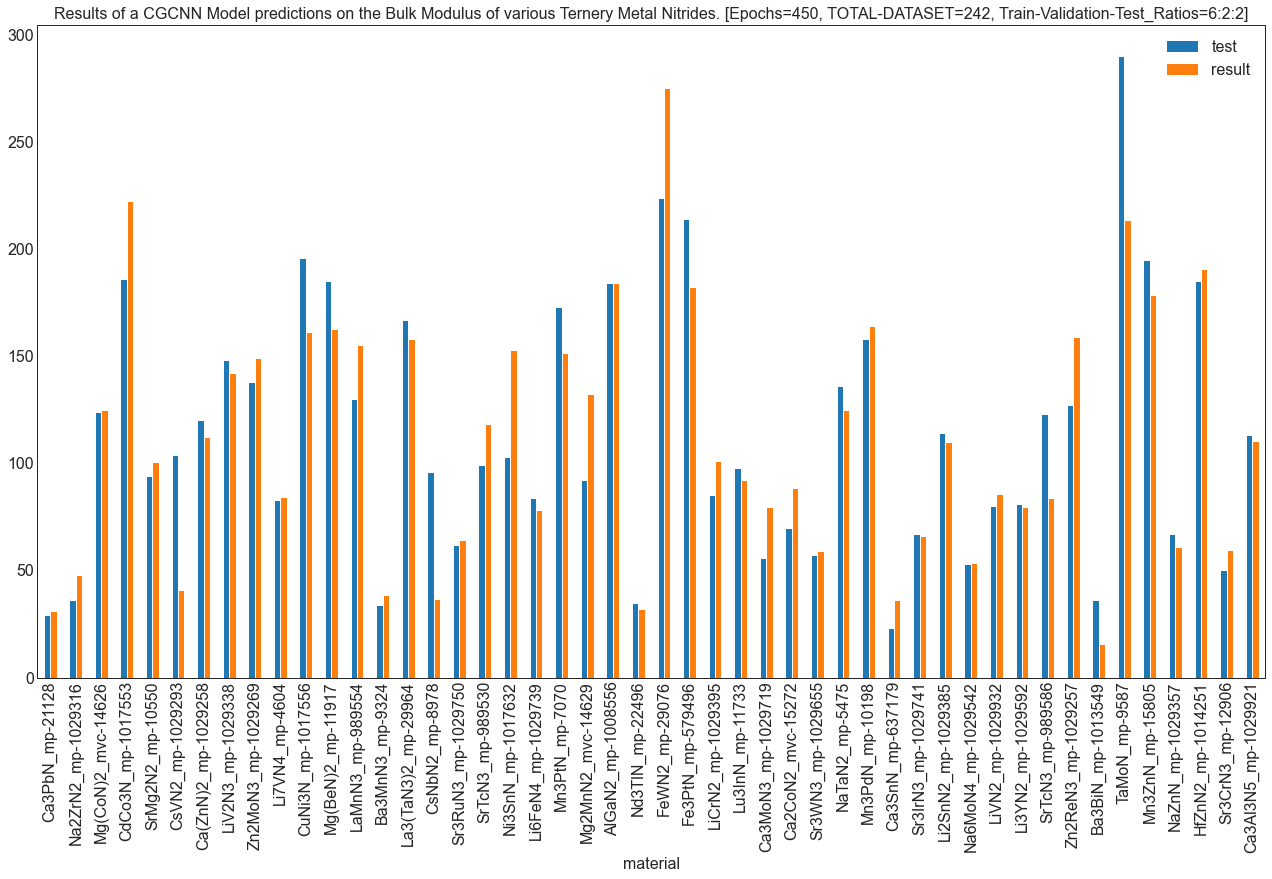

In [86]:
result_file = os.path.join(ROOT_DIR, "utils/test_results.csv")

df = pd.read_csv(result_file)
df.dropna(subset=['material'], inplace=True)
df.head()
df.plot(x="material", y=["test", "result"], kind='bar', figsize=(22, 12),
        title=f"Results of a CGCNN Model predictions on the Bulk Modulus of various Ternery Metal Nitrides. [Epochs={EPOCHS}, TOTAL-DATASET={count}, Train-Validation-Test_Ratios=6:2:2]",
        sort_columns=True)

## RESULT ANALYSIS